# Keras로 간단히 만들어보는 movielens recommender

## 오늘 할 일
1. movielens data(ml-1m) EDA
2. Keras로 간단히 구현해보는 Matrix Factorization
3. 학습(은 생략하고 코드만 보여드립니다)
4. Recommendation

In [1]:
import keras
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# 1. movielens data(ml-1m) EDA

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip; unzip ml-1m ./data/;

--2018-01-21 11:50:46--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  18.3MB/s    in 0.3s    

2018-01-21 11:50:47 (18.3 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
caution: filename not matched:  ./data/


In [3]:
!cd data; ls;

ml-1m  ml-1m.zip


In [4]:
!cd data; ls; cd ml-1m; ls;

ml-1m  ml-1m.zip
movies.dat  ratings.dat  README  users.dat


In [5]:
ratings = pd.read_csv('./data/ml-1m/ratings.dat')

In [6]:
ratings.head()

,1::1193::5::978300760
0,1::661::3::978302109
1,1::914::3::978301968
2,1::3408::4::978300275
3,1::2355::5::978824291
4,1::1197::3::978302268


### ratings.dat 파일의 seperator는 ::, 컬럼 name이 나와있지 않습니다
## 이럴 경우엔 README를 참고해주세요

In [7]:
! cd data/ml-1m/; ls; cat README

movies.dat  ratings.dat  README  users.dat
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without firs

## raintgs.dat 파일은 아래와 같이 구성되어 있습니다
# UserID::MovieID::Rating::Timestamp


- UserIDs range between 1 and 6040
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

### users.dat 파일은 아래와 같이 구성되어 있습니다
# UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is not checked for accuracy. Only users who have provided some demographic information are included in this data set.

### Gender is denoted by a "M" for male and "F" for female
### Age is chosen from the following ranges:
- 1: "Under 18"
- 18: "18-24"
- 25: "25-34"
- 35: "35-44"
- 45: "45-49"
- 50: "50-55"
- 56: "56+"


### Occupation is chosen from the following choices:
- 0: "other" or not specified
- 1: "academic/educator"
- 2: "artist"
- 3: "clerical/admin"
- 4: "college/grad student"
- 5: "customer service"
- 6: "doctor/health care"
- 7: "executive/managerial"
- 8: "farmer"
- 9: "homemaker"
- 10: "K-12 student"
- 11: "lawyer"
- 12: "programmer"
- 13: "retired"
- 14: "sales/marketing"
- 15: "scientist"
- 16: "self-employed"
- 17: "technician/engineer"
- 18: "tradesman/craftsman"
- 19: "unemployed"
- 20: "writer"

In [9]:
AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

In [10]:
ratings = pd.read_csv('./data/ml-1m/ratings.dat', 
                    sep='::', 
                    engine='python', 
                    names=['userid', 'movieid', 'rating', 'timestamp'])

In [11]:
ratings.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [12]:
value_counts = ratings['userid'].value_counts()

In [13]:
value_counts.head(10)
# 4169 유저가 2314개의 평점을 줌

4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
889     1518
3618    1344
2063    1323
1150    1302
1015    1286
Name: userid, dtype: int64

In [14]:
ratings['movieid'].value_counts().head()
# 2858 영화가 3428번 평가됨

2858    3428
260     2991
1196    2990
1210    2883
480     2672
Name: movieid, dtype: int64

In [15]:
ratings['rating'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64

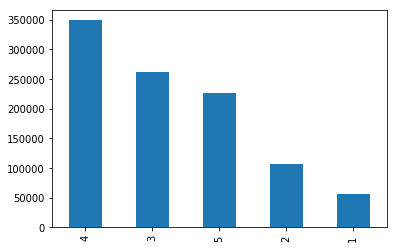

In [16]:
ratings['rating'].value_counts().plot(kind='bar')

In [17]:
t = ratings['rating'].value_counts()

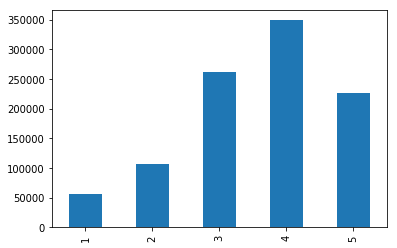

In [18]:
t.sort_index().plot(kind='bar')

In [19]:
ratings['rating'].mean()

3.581564453029317

In [20]:
ratings['rating'].median()

4.0

In [21]:
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()

In [22]:
print(max_userid, max_movieid)

6040 3952


In [23]:
len(ratings['userid'].value_counts())

6040

In [24]:
len(ratings['movieid'].value_counts())
# 3952 - 3706 = 246은 어디에?

3706

In [25]:
# 0부터 시작하기 위해 -1
ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1

In [26]:
print(len(ratings))

1000209


### rating to csv

In [27]:
ratings.to_csv('ml1m_ratings.csv', 
               sep='\t', 
               header=True, 
               columns=['userid', 'movieid', 'rating', 'timestamp', 'user_emb_id', 'movie_emb_id'])

## user

In [29]:
users = pd.read_csv('./data/ml-1m/users.dat', 
                    sep='::', 
                    engine='python', 
                    names=['userid', 'gender', 'age', 'occupation', 'zipcode'])

In [30]:
users.head()

,userid,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [31]:
users['gender'].value_counts()

M    4331
F    1709
Name: gender, dtype: int64

In [32]:
users['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [33]:
users['occupation'].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: occupation, dtype: int64

In [34]:
users['zipcode'].value_counts()

48104         19
22903         18
55104         17
94110         17
10025         16
55105         16
55455         16
55408         15
02138         15
94114         15
90024         14
94117         14
98103         14
90210         13
48103         13
10016         13
60640         13
37922         13
55406         12
48105         11
02139         11
10003         11
55113         11
55405         11
02143         10
13210         10
60201         10
55116         10
10021         10
55112         10
              ..
15137          1
12538          1
04106          1
90248          1
60004          1
92014          1
46580          1
60081          1
74011          1
35115          1
97469          1
12582          1
30340          1
98516          1
72764          1
29708          1
46112          1
76135          1
55030          1
61021          1
06268          1
98107-2117     1
04456          1
49265          1
60482          1
76006          1
63126          1
48118         

In [35]:
# 위에서 정의한대로 매핑
users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])

### Lambda 함수 모르시는 분..?

In [39]:
users['age_desc'].value_counts()

25-34       2096
35-44       1193
18-24       1103
45-49        550
50-55        496
56+          380
Under 18     222
Name: age_desc, dtype: int64

In [40]:
users['occ_desc'].value_counts()

college/grad student      759
other or not specified    711
executive/managerial      679
academic/educator         528
technician/engineer       502
programmer                388
sales/marketing           302
writer                    281
artist                    267
self-employed             241
doctor/health care        236
K-12 student              195
clerical/admin            173
scientist                 144
retired                   142
lawyer                    129
customer service          112
homemaker                  92
unemployed                 72
tradesman/craftsman        70
farmer                     17
Name: occ_desc, dtype: int64

In [41]:
print(len(users), max_userid)

6040 6040


In [42]:
users.to_csv('ml1m_users.csv', 
             sep='\t', 
             header=True, 
             columns=['userid', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc'])

## movie

In [43]:
movies = pd.read_csv('./data/ml-1m/movies.dat', 
                    sep='::', 
                    engine='python', 
                    names=['movieid', 'title', 'genre'])

In [44]:
movies.head()

,movieid,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [45]:
# 중복이 있나 check
sum(movies['title'].value_counts()>=2)

0

In [47]:
print(len(movies))

3883


In [48]:
movies.to_csv('ml1m_movies.csv', 
              sep='\t', 
              header=True, 
              columns=['movieid', 'title', 'genre'])

In [49]:
print(len(ratings['userid'].drop_duplicates()), 'of the', max_userid, 'users rate at least one movie.')

6040 of the 6040 users rate at least one movie.


In [50]:
print(len(ratings['movieid'].drop_duplicates()), 'of the', max_movieid, 'movies are rated.')

3706 of the 3952 movies are rated.


## 참고) 

In [51]:
ml_df = pd.merge(pd.merge(ratings, users), movies)

In [52]:
ml_df.head(2)

,userid,movieid,rating,timestamp,user_emb_id,movie_emb_id,gender,age,occupation,zipcode,age_desc,occ_desc,test_1,title,genre
0,1,1193,5,978300760,0,1192,F,1,10,48067,Under 18,K-12 student,2,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,1,1192,M,56,16,70072,56+,self-employed,3,One Flew Over the Cuckoo's Nest (1975),Drama


In [53]:
mean_ratings = ml_df.pivot_table('rating', index=['title'], columns='gender', aggfunc='mean')

In [54]:
mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


In [55]:
temp = ml_df.pivot_table('rating', index=['title'], columns='gender',aggfunc='count')
temp[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",16.0,21.0
'Night Mother (1986),36.0,34.0
'Til There Was You (1997),37.0,15.0
"'burbs, The (1989)",92.0,211.0
...And Justice for All (1979),35.0,164.0


In [56]:
ratings_count = ml_df.groupby('title').size()

In [57]:
topM = mean_ratings[ratings_count>250].sort_index(by='M', ascending=False)[:10]
topF = mean_ratings[ratings_count>250].sort_index(by='F', ascending=False)[:10]

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  """Entry point for launching an IPython kernel.
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  


In [59]:
topM.head(3)


gender,F,M
title,,
"Godfather, The (1972)",4.314700,4.583333
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),4.481132,4.576628
"Shawshank Redemption, The (1994)",4.539075,4.560625


In [60]:
ratings_active = mean_ratings[ratings_count>250]
ratings_active['diff'] = (ratings_active['F']-ratings_active['M'])
ratings_active.sort_index(by='diff', ascending=False)[:5]


/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,0.676359
Grease (1978),3.975265,3.367041,0.608224
Little Women (1994),3.870588,3.321739,0.548849
Steel Magnolias (1989),3.901734,3.365957,0.535777


In [61]:
ratings_active = mean_ratings[ratings_count>250]
ratings_active['diff'] = (ratings_active['M']-ratings_active['F'])
ratings_active.sort_index(by='diff',ascending=False)[:5]


/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787


In [62]:
ml_df.pivot_table('rating', index=['genre'], columns='age_desc',aggfunc='count').head()

age_desc,18-24,25-34,35-44,45-49,50-55,56+,Under 18
genre,,,,,,,
Action,2075.0,5053.0,2587.0,952.0,935.0,427.0,282.0
Action|Adventure,2020.0,4161.0,2126.0,807.0,727.0,374.0,231.0
Action|Adventure|Animation,104.0,152.0,40.0,13.0,9.0,5.0,22.0
Action|Adventure|Animation|Children's|Fantasy,34.0,34.0,27.0,7.0,6.0,3.0,24.0
Action|Adventure|Animation|Horror|Sci-Fi,106.0,303.0,145.0,32.0,18.0,4.0,10.0


In [63]:
ml_df.pivot_table('rating', index=['genre'], columns='age_desc',aggfunc='mean').head()

age_desc,18-24,25-34,35-44,45-49,50-55,56+,Under 18
genre,,,,,,,
Action,3.233253,3.282209,3.460765,3.442227,3.527273,3.566745,3.393617
Action|Adventure,3.636634,3.713771,3.642051,3.598513,3.734525,3.764706,3.632035
Action|Adventure|Animation,4.250000,4.059211,4.150000,3.846154,3.888889,3.800000,4.636364
Action|Adventure|Animation|Children's|Fantasy,2.588235,2.411765,2.814815,3.000000,3.333333,3.000000,2.875000
Action|Adventure|Animation|Horror|Sci-Fi,3.433962,3.620462,3.531034,3.125000,3.888889,3.250000,3.600000


In [64]:
ml_df.pivot_table('rating', index=['title'], columns='age_desc',aggfunc='count').head()

age_desc,18-24,25-34,35-44,45-49,50-55,56+,Under 18
title,,,,,,,
"$1,000,000 Duck (1971)",6.0,11.0,15.0,1.0,4.0,NaN,NaN
'Night Mother (1986),3.0,26.0,21.0,6.0,9.0,3.0,2.0
'Til There Was You (1997),8.0,24.0,10.0,3.0,2.0,3.0,2.0
"'burbs, The (1989)",90.0,115.0,55.0,11.0,24.0,6.0,2.0
...And Justice for All (1979),7.0,58.0,70.0,20.0,29.0,14.0,1.0


In [65]:
ml_df.pivot_table('rating', index=['title'], columns='age_desc',aggfunc='mean').head()

age_desc,18-24,25-34,35-44,45-49,50-55,56+,Under 18
title,,,,,,,
"$1,000,000 Duck (1971)",3.000000,3.090909,3.133333,2.000000,2.750000,NaN,NaN
'Night Mother (1986),4.666667,3.423077,2.904762,3.833333,3.555556,4.333333,2.0
'Til There Was You (1997),2.500000,2.666667,2.900000,2.333333,2.500000,2.666667,3.5
"'burbs, The (1989)",3.244444,2.652174,2.818182,2.545455,3.208333,2.666667,4.5
...And Justice for All (1979),3.428571,3.724138,3.657143,4.100000,3.551724,3.928571,3.0


In [66]:
ml_df.pivot_table('rating', index=['title'], columns='occ_desc',aggfunc='count').head()

occ_desc,K-12 student,academic/educator,artist,clerical/admin,college/grad student,customer service,doctor/health care,executive/managerial,farmer,homemaker,...,other or not specified,programmer,retired,sales/marketing,scientist,self-employed,technician/engineer,tradesman/craftsman,unemployed,writer
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",NaN,6.0,NaN,1.0,5.0,1.0,3.0,3.0,NaN,3.0,...,5.0,1.0,1.0,NaN,NaN,1.0,2.0,NaN,2.0,3.0
'Night Mother (1986),1.0,7.0,3.0,5.0,6.0,4.0,4.0,11.0,NaN,NaN,...,13.0,NaN,3.0,2.0,2.0,1.0,2.0,2.0,NaN,3.0
'Til There Was You (1997),2.0,6.0,2.0,5.0,6.0,NaN,4.0,7.0,NaN,NaN,...,3.0,1.0,1.0,5.0,NaN,2.0,2.0,1.0,1.0,3.0
"'burbs, The (1989)",1.0,24.0,20.0,18.0,45.0,12.0,8.0,26.0,1.0,5.0,...,31.0,15.0,NaN,16.0,5.0,12.0,24.0,10.0,5.0,21.0
...And Justice for All (1979),1.0,20.0,6.0,8.0,9.0,4.0,9.0,33.0,NaN,2.0,...,33.0,4.0,6.0,13.0,3.0,12.0,11.0,4.0,1.0,14.0


In [67]:
ml_df.pivot_table('rating', index=['title'], columns='occ_desc',aggfunc='mean').head()

occ_desc,K-12 student,academic/educator,artist,clerical/admin,college/grad student,customer service,doctor/health care,executive/managerial,farmer,homemaker,...,other or not specified,programmer,retired,sales/marketing,scientist,self-employed,technician/engineer,tradesman/craftsman,unemployed,writer
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",NaN,2.166667,NaN,4.000000,2.800000,4.000000,3.000000,3.000000,NaN,3.666667,...,3.800000,1.000000,2.000000,NaN,NaN,5.000000,3.500000,NaN,3.5,2.333333
'Night Mother (1986),1.0,3.714286,3.000000,3.400000,3.666667,3.750000,3.500000,3.545455,NaN,NaN,...,2.615385,NaN,4.666667,3.500000,3.5,3.000000,2.500000,4.50,NaN,3.000000
'Til There Was You (1997),3.5,2.666667,2.500000,2.200000,3.333333,NaN,2.000000,2.857143,NaN,NaN,...,2.666667,3.000000,4.000000,2.600000,NaN,1.500000,4.000000,1.00,2.0,2.333333
"'burbs, The (1989)",5.0,2.958333,2.950000,2.833333,3.022222,2.916667,2.625000,2.615385,5.0,2.800000,...,2.580645,2.933333,NaN,3.250000,3.2,2.833333,3.000000,3.10,3.4,3.000000
...And Justice for All (1979),3.0,3.650000,3.833333,2.875000,3.444444,3.750000,3.888889,3.848485,NaN,3.500000,...,3.606061,3.500000,4.000000,3.538462,4.0,4.000000,4.090909,3.75,4.0,3.714286


# 2. Keras로 간단히 구현해보는 Matrix Factorization

http://www.fenris.org/2016/03/07/collaborative-filtering-in-keras

기본 아이디어 : 각 사용자가 작성한 영화의 평점이 열과 행이 있는 사용자 행렬로 표현되어, 사용자들의 특성을 나타낼 수 있음

In [69]:
import numpy as np
from keras.layers import Embedding, Reshape, Merge, Dropout, Dense
from keras.models import Sequential

In [70]:
class CFModel(Sequential):
    def __init__(self, n_users, m_items, k_factors, **kwargs):
        super(CFModel, self).__init__(**kwargs)
        P = Sequential()
        P.add(Embedding(n_users, k_factors, input_length=1))
        P.add(Reshape((k_factors,)))
        Q = Sequential()
        Q.add(Embedding(m_items, k_factors, input_length=1))
        Q.add(Reshape((k_factors,)))
        self.add(Merge([P, Q], mode='dot', dot_axes=1)) # dot : 행렬의 곱

    def rate(self, user_id, item_id):
        return self.predict([np.array([user_id]), np.array([item_id])])[0][0]

# Train

In [71]:
%matplotlib inline
import math
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from CFModel import CFModel
from keras.utils import multi_gpu_model

In [72]:
K_FACTORS = 120

In [73]:
ratings = pd.read_csv('./ml1m_ratings.csv', 
                      sep='\t', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print(len(ratings), 'ratings loaded.')

1000209 ratings loaded.


In [74]:
shuffled_ratings = ratings.sample(frac=1., random_state=7777) # shuffling 
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)
Movies = shuffled_ratings['movie_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [2347 3567 1512 ..., 4772 4512 5845] , shape = (1000209,)
Movies: [2193 1213 1255 ...,  732 3622 2394] , shape = (1000209,)
Ratings: [3 5 3 ..., 5 4 4] , shape = (1000209,)


### pd.sample

# 3. 학습

In [75]:
model = CFModel(max_userid, max_movieid, K_FACTORS)
# model = multi_gpu_model(model, gpus=2)
model.compile(loss='mse', optimizer='adamax')

/home/kyle/workspace/keras/CFModel.py:15: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  self.add(Merge([P, Q], mode='dot', dot_axes=1))


### EarlyStopping : Stop training when a monitored quantity has stopped improving
- patience : 개선이 없다고 바로 종료하는 것이 아닌, 개선이 없는 에포크를 몇번 더 기다릴 것인가!
- ex) patience=10이면 개선이 없는 에포크가 10번 지속되면 학습을 종료

### ModelCheckpoint : Save the model after every epoch
- 가장 좋은 모델을 저장

[model fit](https://www.slideshare.net/madvirus/keras-intro)

In [81]:
%%time
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('ml1m_weights.h5', save_best_only=True)]
history = model.fit([Users, Movies], Ratings, nb_epoch=30, validation_split=.1, verbose=2, callbacks=callbacks)

/home/kyle/anaconda3/lib/python3.6/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 900188 samples, validate on 100021 samples
Epoch 1/30
 - 73s - loss: 8.0573 - val_loss: 2.1152
Epoch 2/30
 - 75s - loss: 1.4040 - val_loss: 1.0871
Epoch 3/30
 - 75s - loss: 0.9684 - val_loss: 0.9161
Epoch 4/30
 - 75s - loss: 0.8668 - val_loss: 0.8593
Epoch 5/30
 - 75s - loss: 0.8204 - val_loss: 0.8280
Epoch 6/30
 - 75s - loss: 0.7900 - val_loss: 0.8107
Epoch 7/30
 - 75s - loss: 0.7652 - val_loss: 0.7959
Epoch 8/30
 - 75s - loss: 0.7415 - val_loss: 0.7826
Epoch 9/30
 - 75s - loss: 0.7183 - val_loss: 0.7726
Epoch 10/30
 - 75s - loss: 0.6947 - val_loss: 0.7647
Epoch 11/30
 - 75s - loss: 0.6709 - val_loss: 0.7591
Epoch 12/30
 - 75s - loss: 0.6469 - val_loss: 0.7535
Epoch 13/30
 - 75s - loss: 0.6227 - val_loss: 0.7503
Epoch 14/30
 - 75s - loss: 0.5980 - val_loss: 0.7500
Epoch 15/30
 - 75s - loss: 0.5733 - val_loss: 0.7508
Epoch 16/30
 - 75s - loss: 0.5489 - val_loss: 0.7522
CPU times: user 48min 7s, sys: 10min 54s, total: 59min 1s
Wall time: 19min 55s


In [83]:
model.save('ml1m_weights_new.h5')

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


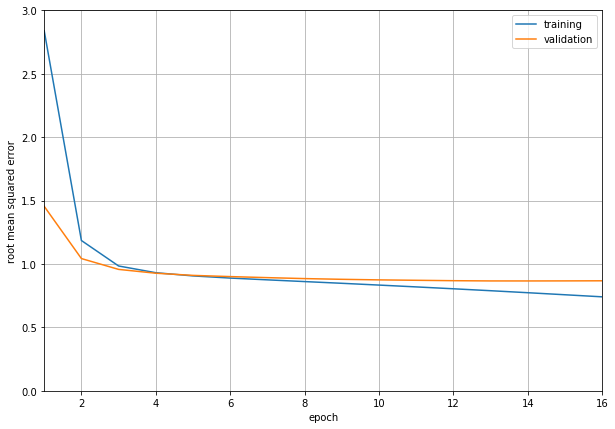

In [84]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
ax = loss.ix[:,:].plot(x='epoch', figsize={7,10}, grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([0.0,3.0]);

In [85]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))


Minimum RMSE at epoch 14 = 0.8661


In [86]:
# multi gpu : keras 2.0.9 이상부터 추가됨
model = CFModel(max_userid, max_movieid, K_FACTORS)
model = multi_gpu_model(model, gpus=2)
model.compile(loss='mse', optimizer='adamax')

# 4. Recommendation

In [87]:
K_FACTORS = 120
TEST_USER = 3000

In [88]:
ratings = pd.read_csv('ml1m_ratings.csv', sep='\t', usecols=['userid', 'movieid', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print(len(ratings), 'ratings loaded.')

1000209 ratings loaded.


In [89]:
users = pd.read_csv('ml1m_users.csv', sep='\t', usecols=['userid', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
print(len(users), 'descriptions of', max_userid, 'users loaded.')

6040 descriptions of 6040 users loaded.


In [90]:
movies = pd.read_csv('ml1m_movies.csv', sep='\t', usecols=['movieid', 'title', 'genre'])
print(len(movies), 'descriptions of', max_movieid, 'movies loaded.')

3883 descriptions of 3952 movies loaded.


In [91]:
trained_model = CFModel(max_userid, max_movieid, K_FACTORS)

/home/kyle/workspace/keras/CFModel.py:15: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  self.add(Merge([P, Q], mode='dot', dot_axes=1))


In [92]:
trained_model.load_weights('ml1m_weights.h5')

In [93]:
users[users['userid'] == TEST_USER]

,userid,gender,zipcode,age_desc,occ_desc
2999,3000,M,55408,25-34,college/grad student


In [94]:
def predict_rating(userid, movieid):
    return trained_model.rate(userid - 1, movieid - 1) # -1 한 이유는 임베딩을 위해

In [95]:
user_ratings = ratings[ratings['userid'] == TEST_USER][['userid', 'movieid', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movieid']), axis=1)

In [96]:
user_ratings.head()

,userid,movieid,rating,prediction
487650,3000,2987,4,3.979063
487651,3000,2990,3,2.655224
487652,3000,3793,3,3.664937
487653,3000,1252,4,3.979287
487654,3000,2997,4,4.287364


In [97]:
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                ).head(10)

,userid,movieid,rating,prediction,title,genre
0,3000,590,5,3.311633,Dances with Wolves (1990),Adventure|Drama|Western
1,3000,3552,5,3.529943,Caddyshack (1980),Comedy
2,3000,2858,5,4.574814,American Beauty (1999),Comedy|Drama
3,3000,3358,5,3.227030,Defending Your Life (1991),Comedy|Romance
4,3000,2968,5,3.614336,Time Bandits (1981),Adventure|Fantasy|Sci-Fi
5,3000,1307,5,3.791792,When Harry Met Sally... (1989),Comedy|Romance
6,3000,144,5,2.947541,"Brothers McMullen, The (1995)",Comedy
7,3000,1193,5,3.988797,One Flew Over the Cuckoo's Nest (1975),Drama
8,3000,1265,5,4.078602,Groundhog Day (1993),Comedy|Romance
9,3000,733,5,3.236242,"Rock, The (1996)",Action|Adventure|Thriller


In [98]:
ratings['movieid'].isin(user_ratings['movieid']).head()

0     True
1    False
2    False
3    False
4    False
Name: movieid, dtype: bool

In [99]:
recommendations = ratings[ratings['movieid'].isin(user_ratings['movieid']) == False][['movieid']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TEST_USER, x['movieid']), axis=1)

In [100]:
recommendations.head()

,movieid,prediction
1,661,2.947822
2,914,3.201451
3,3408,2.965931
4,2355,3.538394
6,1287,3.171303


In [101]:
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movieid',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(10)

,movieid,prediction,title,genre
0,2959,4.405322,Fight Club (1999),Drama
1,1136,4.347965,Monty Python and the Holy Grail (1974),Comedy
2,50,4.261983,"Usual Suspects, The (1995)",Crime|Thriller
3,1148,4.260325,"Wrong Trousers, The (1993)",Animation|Comedy
4,296,4.242664,Pulp Fiction (1994),Crime|Drama
5,2692,4.232467,Run Lola Run (Lola rennt) (1998),Action|Crime|Romance
6,593,4.166513,"Silence of the Lambs, The (1991)",Drama|Thriller
7,318,4.164229,"Shawshank Redemption, The (1994)",Drama
8,1617,4.149546,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
9,858,4.131681,"Godfather, The (1972)",Action|Crime|Drama


In [102]:
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                ).head(10)

,userid,movieid,rating,prediction,title,genre
0,3000,590,5,3.311633,Dances with Wolves (1990),Adventure|Drama|Western
1,3000,3552,5,3.529943,Caddyshack (1980),Comedy
2,3000,2858,5,4.574814,American Beauty (1999),Comedy|Drama
3,3000,3358,5,3.227030,Defending Your Life (1991),Comedy|Romance
4,3000,2968,5,3.614336,Time Bandits (1981),Adventure|Fantasy|Sci-Fi
5,3000,1307,5,3.791792,When Harry Met Sally... (1989),Comedy|Romance
6,3000,144,5,2.947541,"Brothers McMullen, The (1995)",Comedy
7,3000,1193,5,3.988797,One Flew Over the Cuckoo's Nest (1975),Drama
8,3000,1265,5,4.078602,Groundhog Day (1993),Comedy|Romance
9,3000,733,5,3.236242,"Rock, The (1996)",Action|Adventure|Thriller
